# Generative Adversarial Networks

This code is based on [_Generative Adversarial Networks (2014)_](https://arxiv.org/abs/1406.2661) paper by Ian J. Goodfellow, Jean Pouget-Abadie, et all.

![title](https://github.com/DSC-UI-SRIN/Introduction-to-GAN/raw/master/1%20-%20Fundamental%20of%20GANs/images/minmax.png)

## Setup Environment

In [1]:
# code style linter
%load_ext pycodestyle_magic
%flake8_on

1: E999 SyntaxError: invalid syntax


In [2]:
import torch

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using %s" % (device))

using cuda


## Prepare Dataset

In [3]:
from torchvision import datasets, transforms

# setup MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

mnist_dataset = datasets.MNIST(
    root="./datasets", train=True, transform=transform, download=True)

mnist_width = mnist_dataset.train_data.size(1)
mnist_height = mnist_dataset.train_data.size(2)
mnist_shape = [1, mnist_width, mnist_height]

# data loader (input pipeline)
data_loader = torch.utils.data.DataLoader(
    dataset=mnist_dataset, batch_size=100, shuffle=True)

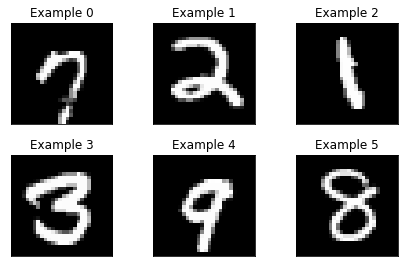

In [4]:
import matplotlib.pyplot as plt

examples = enumerate(data_loader)
_, (example_data, _) = next(examples)

# plot example data
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Example %d" % i)
    plt.xticks([])
    plt.yticks([])

plt.show()

## Build Model

![title](https://miro.medium.com/max/1600/1*M_YipQF_oC6owsU1VVrfhg.jpeg)
source: https://medium.com/@jonathan_hui/gan-whats-generative-adversarial-networks-and-its-application-f39ed278ef09

In [5]:
import torch.nn as nn


def nn_block(in_feat, out_feat, normalize=False):
    layers = [nn.Linear(in_feat, out_feat)]
    if normalize:
        layers.append(nn.BatchNorm1d(out_feat, 0.8))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return layers

In [6]:
# generator model
class Generator(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            *nn_block(in_dim, 128),
            *nn_block(128, 256, normalize=True),
            *nn_block(256, 512, normalize=True),
            *nn_block(512, 1024, normalize=True),
            nn.Linear(1024, out_dim),
            nn.Tanh())

    def forward(self, noise):
        output = self.model(noise)
        image = output.view(output.size(0), -1)
        return image

In [7]:
# discriminator model
class Discriminator(nn.Module):
    def __init__(self, in_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            *nn_block(in_dim, 512),
            *nn_block(512, 256),
            nn.Linear(256, 1),
            nn.Sigmoid())

    def forward(self, image):
        img_flat = image.view(image.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [8]:
noise_dim = 100
mnist_dim = mnist_width * mnist_height

# build model
generator = Generator(in_dim=noise_dim, out_dim=mnist_dim).to(device)
discriminator = Discriminator(in_dim=mnist_dim).to(device)

print(generator, discriminator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
) Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)

## Train Process

### Discriminator Update

![title](https://miro.medium.com/max/1720/1*4xAHMaUGXeOQnNJhzjq-4Q.jpeg)

### Generator Update

#### Before:

![title](https://miro.medium.com/max/1224/1*n235XEigXKL3ktL08d-CZA.jpeg)

#### Because Generator diminished gradient:

In practice, equation 1 may not provide sufficient gradient for G to learn well.  Early in learning, when G is poor,D can reject samples with high confidence because they are clearly different fromthe training data.  In this case, log(1−D(G(z))) saturates.  Rather than training G to minimize log(1−D(G(z))) we can train G to maximize logD(G(z)). This objective function results in thesame fixed point of the dynamics of G and D but provides much stronger gradients early in learning. (GAN Paper)

![title](https://miro.medium.com/max/1517/1*6So6q3dWurG8qrmwk1y3jw.jpeg)

![BCEloss](https://github.com/DSC-UI-SRIN/Introduction-to-GAN/raw/master/1%20-%20Fundamental%20of%20GANs/images/BCELoss.png)

In [9]:
# loss criterion
criterion = nn.BCELoss().to(device)

# optimizers
g_optimizer = torch.optim.Adam(
    generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

d_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

FloatTensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [10]:
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import os

g_losses = []
d_losses = []

# train process
epochs = 200
for epoch in range(epochs):

    g_loss_sum = 0
    d_loss_sum = 0

    for i, (imgs, _) in enumerate(data_loader):

        batch_size = imgs.size(0)

        # adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0),
                         requires_grad=False)

        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0),
                        requires_grad=False)

        # configure input
        real_imgs = Variable(imgs.type(FloatTensor))

        # -----------------
        #  Train Generator
        # -----------------

        g_optimizer.zero_grad()

        # sample noise as generator input
        noise = Variable(FloatTensor(
            np.random.normal(0, 1, (batch_size, noise_dim))))

        # generate a batch of images
        gen_imgs = generator(noise)

        # loss measures generator's ability to fool the discriminator
        # g_loss = criterion(discriminator(gen_imgs), fake)  # Normal MinMax
        g_loss = criterion(discriminator(gen_imgs), valid)  # Non Saturated

        g_loss.backward()
        g_optimizer.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        d_optimizer.zero_grad()

        # loss measures discriminator's ability to classify real
        # from generated samples
        real_loss = criterion(discriminator(real_imgs), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        d_optimizer.step()

        print("\r[Epoch %d/%d] [Batch %d/%d]"
              % (epoch+1, epochs, i+1, len(data_loader)), end='')

        print(" [G loss: %f] [D loss: %f]"
              % (g_loss.item(), d_loss.item()), end='')

        g_loss_sum += g_loss.item()
        d_loss_sum += d_loss.item()

    g_losses.append(g_loss_sum / len(data_loader))
    d_losses.append(d_loss_sum / len(data_loader))

    if (epoch + 1) % 10 == 0:
        # sample noise as generator input
        noise = Variable(FloatTensor(
            np.random.normal(0, 1, (5 * 5, noise_dim))))

        # generate a batch of sample images
        gen_imgs = generator(noise)

        # save sample images
        os.makedirs("./samples/gan", exist_ok=True)
        save_image(gen_imgs.view(gen_imgs.size(0), *mnist_shape),
                   "./samples/gan/sample_%03d.png" % (epoch + 1),
                   nrow=5, normalize=True)

# save result models
os.makedirs("./models/gan", exist_ok=True)
torch.save(generator, "./models/gan/generator.pt")
torch.save(discriminator, "./models/gan/discriminator.pt")

[Epoch 200/200] [Batch 600/600] [G loss: 8.470739] [D loss: 0.729795]

## Train Result

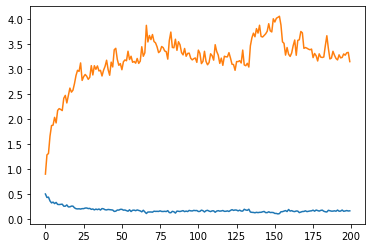

In [11]:
# Plot losses
plt.plot(d_losses, label="discriminator loss")
plt.plot(g_losses, label="generator loss")
plt.show()

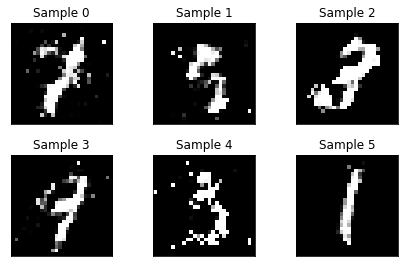

In [12]:
# sample noise as generator input
noise = Variable(FloatTensor(np.random.normal(0, 1, (6, noise_dim))))

# generate a batch of sample images
gen_imgs = generator(noise)

# plot sample images
imgs = gen_imgs.view(gen_imgs.size(0), *mnist_shape).cpu().detach().numpy()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(imgs[i][0], cmap='gray', interpolation='none')
    plt.title("Sample %d" % i)
    plt.xticks([])
    plt.yticks([])

plt.show()